# Illinois Bundleflower NIR Modeling

### Module Imports

In [22]:
import mlflow
import numpy as np
import polars as pl
import astartes as at
import matplotlib.pyplot as plt

from typing import Iterable

from mlflow.models import infer_signature
from itertools import compress
from scipy.signal import savgol_filter
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler

### Custom Functions and Classes

In [23]:
# Filter function to get rid of low quality spectra
def filter_spectra(X: np.ndarray, threshold: int) -> np.ndarray:
    """
    Takes a Numpy array and filters out any spectra with low spread between the minimum and maximum value of the spectra
    Returns a filtered Numpy array of spectra
    """
    spread = X.max(axis=1) - X.min(axis=1)
    idx = spread > threshold

    return X[idx], idx

def wavenumber_to_nm(X: Iterable):
    """ Convert Iterable wavenumber per cm to wavelength(nm)"""
    # Sort X from hi to lo
    X = sorted(list(X), reverse=True)
    # Convert from wavenumber/cm to wavelength(nm)
    nm = list(map(lambda x: 10**7 / float(x), X))
    
    return nm
    
def nm_to_wavenumber(X):
    """ Convert Iterable wavelength(nm) to wavenumber per cm """
    # Sort X from lo to hi
    X = sorted(list(X))
    # Convert from wavelength(nm) to wavenumber/cm
    wavenumber = list(map(lambda x: 1/(10**-7 * float(x)), X))

    return wavenumber

def error_fig(gt, preds, title, block=None):
    mapping = {
        'ward': 'red',
        'dairyland': 'blue'
    }
    fig, ax = plt.subplots()
    if block is not None:
        for block_name in np.unique(block):
            idx = [x == block_name for x in block]
            sub_preds = list(compress(preds, idx))
            sub_gt = list(compress(gt, idx))
            ax.scatter(sub_gt, sub_preds, color=mapping.get(block_name), alpha=0.6, label=block_name)
        ax.legend(loc="upper left", title="Wetchem origin")
    else:
        ax.scatter(gt, preds, color='blue', alpha=0.6)
    ax.set_title(title)
    ax.set_xlabel('Ground Truth')
    ax.set_ylabel("Predictions")
    ax.axline((0, 0), slope=1, color='green', linestyle='--')

    min_val = min(gt.min(), preds.min())
    max_val = max(gt.max(), preds.max())

    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)

    plt.close(fig)

    return fig

class EquidistantInterpolator(BaseEstimator):
    """
    Ascending sort and linearly interpolate data with equidistant wavelength steps
    """

    def __init__(self, lambda_nm: np.ndarray=None):
        self.lambda_nm = lambda_nm

    def fit(self, X=None, y=None):
        return self

    def transform(self, X, y=None):
        
        sort_idx = np.argsort(self.lambda_nm)
        lambda_nm = self.lambda_nm[sort_idx]
        min_nm = np.min(lambda_nm)
        max_nm = np.max(lambda_nm)
        equi_nm = np.linspace(start=min_nm, stop=max_nm, num=len(lambda_nm))
        self.equidistant_lambda_nm = equi_nm

        X = X[:, sort_idx]
        self.transformed_X = np.array(
            [
                np.interp(
                    x=equi_nm,
                    xp=lambda_nm,
                    fp=row
                ) for row in X
            ]
        )
        
        return self.transformed_X

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)
        

class SavgolTransform(BaseEstimator):
    """
    Implement a Savitsky Golay filter as a preprocessing step
    Returns the filtered, derivitized data
    """    
    def __init__(self, window_length: int=10, polyorder: int=5, deriv: int=2):
        """ Initialize and allow keyword arguments to be passed """
        self.window_length=window_length
        self.polyorder = polyorder
        self.deriv = deriv

    def fit(self, X=None, y=None):
        """ Not implemented, return self """
        return self

    def transform(self, X):
        """ Transform the X matrix of spectra with a Savgol filter according to initialized attributes """
        X_filtered = savgol_filter(
            x=X,
            window_length=self.window_length,
            polyorder=self.polyorder,
            deriv=self.deriv
        )
        return X_filtered

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)



### Read in Data

In [24]:
raw_1mm_spectra = pl.read_csv('../data/lumpkin_ibf_nir_spectra_1mm.csv')
raw_10mm_spectra = pl.read_csv('../data/lumpkin_ibf_nir_spectra_10mm.csv')
raw_wetchem = pl.read_csv('../data/lumpkin_ibf_wet_chemistry_results.csv', null_values='NA')
raw_yield = pl.read_csv("../data/lumpkin_ibf_forage_yield.csv")

In [25]:
# Print the first ten column names
print(raw_1mm_spectra.columns[:10])

['Sample Name', 'Device Id', 'Created At', 'Created By', '2549.999982425943', '2541.1764576690834', '2532.413784775524', '2523.711336406793', '2515.0684938180916', '2506.4846467116427']


In [26]:
raw_wetchem.head()

shape: (5, 13)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ sample_name ‚îÜ material     ‚îÜ lab  ‚îÜ moisture_pct ‚îÜ ‚Ä¶ ‚îÜ total_diges ‚îÜ nem_adf ‚îÜ neg_adf ‚îÜ nel_adf ‚îÇ
‚îÇ ---         ‚îÜ ---          ‚îÜ ---  ‚îÜ ---          ‚îÜ   ‚îÜ tible_nutri ‚îÜ ---     ‚îÜ ---     ‚îÜ ---     ‚îÇ
‚îÇ str         ‚îÜ str          ‚îÜ str  ‚îÜ f64          ‚îÜ   ‚îÜ ents        ‚îÜ f64     ‚îÜ f64     ‚îÜ f64     ‚îÇ
‚îÇ             ‚îÜ              ‚îÜ      ‚îÜ              ‚îÜ   ‚îÜ ---         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÇ
‚îÇ             ‚îÜ              ‚îÜ      ‚îÜ              ‚îÜ   ‚îÜ f64         ‚îÜ         ‚îÜ         ‚îÜ         ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ LMP-101     ‚îÜ ibf_stems_le ‚îÜ ward ‚îÜ 7.61         ‚îÜ ‚Ä¶ ‚îÜ 58.4        ‚îÜ 56.98   ‚îÜ 31.18   ‚îÜ 66.02   ‚îÇ
‚îÇ             ‚îÜ aves         ‚îÜ      ‚îÜ              ‚îÜ   ‚îÜ             ‚îÜ         ‚îÜ         ‚îÜ         ‚îÇ
‚îÇ LMP-111     ‚îÜ ibf_stems_le ‚îÜ ward ‚îÜ 8.19         ‚îÜ ‚Ä¶ ‚îÜ 53.8        ‚îÜ 49.84   ‚îÜ 24.61   ‚îÜ 58.69   ‚îÇ
‚îÇ             ‚îÜ aves         ‚îÜ      ‚îÜ              ‚îÜ   ‚îÜ             ‚îÜ         ‚îÜ         ‚îÜ         ‚îÇ
‚îÇ LMP-117     ‚îÜ ibf_stems_le ‚îÜ ward ‚îÜ 8.06         ‚îÜ ‚Ä¶ ‚îÜ 54.6        ‚îÜ 51.08   ‚îÜ 25.76   ‚îÜ 59.95   ‚îÇ
‚îÇ             ‚îÜ aves         ‚îÜ      ‚îÜ              ‚îÜ   ‚îÜ             ‚îÜ         ‚îÜ         ‚îÜ         ‚îÇ
‚îÇ LMP-121     ‚îÜ ibf_stems_le ‚îÜ ward ‚îÜ 8.42         ‚îÜ ‚Ä¶ ‚îÜ 57.4        ‚îÜ 55.48   ‚îÜ 29.81   ‚îÜ 64.46   ‚îÇ
‚îÇ             ‚îÜ aves         ‚îÜ      ‚îÜ              ‚îÜ   ‚îÜ             ‚îÜ         ‚îÜ         ‚îÜ         ‚îÇ
‚îÇ LMP-124     ‚îÜ ibf_stems_le ‚îÜ ward ‚îÜ 8.09         ‚îÜ ‚Ä¶ ‚îÜ 58.5        ‚îÜ 57.2    ‚îÜ 31.38   ‚îÜ 66.25   ‚îÇ
‚îÇ             ‚îÜ aves         ‚îÜ      ‚îÜ              ‚îÜ   ‚îÜ             ‚îÜ         ‚îÜ         ‚îÜ         ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

### Filter out low quality spectra for 1mm forage

In [27]:
# Get filter index for high quality spectra
raw_1mm_X = raw_1mm_spectra[:, 4:]
_, idx = filter_spectra(raw_1mm_X.to_numpy(), threshold=10)

# Split 'Sample Name' into 'sample_name' and 'rep'
cleaned_name_df = raw_1mm_spectra\
    .select(
        pl.col('Sample Name')\
        .str\
        .split('_')\
        .list\
        .to_struct("max_width", ['sample_name', 'rep'])
    ).unnest('Sample Name')

# Combine new name columns with spectra and filter
raw_1mm_spectra_df = pl.concat([cleaned_name_df, raw_1mm_spectra[:, 4:]], how='horizontal')\
    .filter(idx)

raw_1mm_spectra_df.head()

shape: (5, 259)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ sample_nam ‚îÜ rep ‚îÜ 2549.99998 ‚îÜ 2541.17645 ‚îÜ ‚Ä¶ ‚îÜ 1357.48645 ‚îÜ 1354.98187 ‚îÜ 1352.4865 ‚îÜ 1350.0003 ‚îÇ
‚îÇ e          ‚îÜ --- ‚îÜ 2425943    ‚îÜ 76690834   ‚îÜ   ‚îÜ 91101118   ‚îÜ 22425105   ‚îÜ 103700236 ‚îÜ 226195302 ‚îÇ
‚îÇ ---        ‚îÜ str ‚îÜ ---        ‚îÜ ---        ‚îÜ   ‚îÜ ---        ‚îÜ ---        ‚îÜ ---       ‚îÜ ---       ‚îÇ
‚îÇ str        ‚îÜ     ‚îÜ f64        ‚îÜ f64        ‚îÜ   ‚îÜ f64        ‚îÜ f64        ‚îÜ f64       ‚îÜ f64       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ LMP-406    ‚îÜ 2   ‚îÜ 48.845921  ‚îÜ 48.401282  ‚îÜ ‚Ä¶ ‚îÜ 92.405098  ‚îÜ 92.726154  ‚îÜ 93.015502 ‚îÜ 93.209764 ‚îÇ
‚îÇ LMP-406    ‚îÜ 1   ‚îÜ 48.990801  ‚îÜ 48.477955  ‚îÜ ‚Ä¶ ‚îÜ 92.633122  ‚îÜ 92.9062    ‚îÜ 93.13659  ‚îÜ 93.302278 ‚îÇ
‚îÇ LMP-172    ‚îÜ 2   ‚îÜ 49.876259  ‚îÜ 49.455092  ‚îÜ ‚Ä¶ ‚îÜ 93.11483   ‚îÜ 93.275293  ‚îÜ 93.349254 ‚îÜ 93.384201 ‚îÇ
‚îÇ LMP-172    ‚îÜ 1   ‚îÜ 50.084559  ‚îÜ 49.56703   ‚îÜ ‚Ä¶ ‚îÜ 93.167666  ‚îÜ 93.375118  ‚îÜ 93.499549 ‚îÜ 93.592565 ‚îÇ
‚îÇ LMP-180    ‚îÜ 2   ‚îÜ 54.036062  ‚îÜ 53.498033  ‚îÜ ‚Ä¶ ‚îÜ 94.917704  ‚îÜ 95.14381   ‚îÜ 95.295302 ‚îÜ 95.382811 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

### Filter out low quality spectra for 10mm forage

In [28]:
# Get filter index for high quality spectra
raw_10mm_X = raw_10mm_spectra[:, 4:]
_, idx = filter_spectra(raw_10mm_X.to_numpy(), threshold=10)

# Split 'Sample Name' into 'sample_name' and 'rep'
cleaned_name_df = raw_10mm_spectra\
    .select(
        pl.col('Sample Name')\
        .str\
        .split('_')\
        .list\
        .to_struct("max_width", ['sample_name', 'rep'])
    ).unnest('Sample Name')

# Combine new name columns with spectra and filter
raw_10mm_spectra_df = pl.concat([cleaned_name_df, raw_10mm_spectra[:, 4:]], how='horizontal')\
    .filter(idx)

raw_10mm_spectra_df.head()

shape: (5, 259)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ sample_nam ‚îÜ rep ‚îÜ 2549.99998 ‚îÜ 2541.17645 ‚îÜ ‚Ä¶ ‚îÜ 1357.48645 ‚îÜ 1354.98187 ‚îÜ 1352.4865 ‚îÜ 1350.0003 ‚îÇ
‚îÇ e          ‚îÜ --- ‚îÜ 2425943    ‚îÜ 76690834   ‚îÜ   ‚îÜ 91101118   ‚îÜ 22425105   ‚îÜ 103700236 ‚îÜ 226195302 ‚îÇ
‚îÇ ---        ‚îÜ str ‚îÜ ---        ‚îÜ ---        ‚îÜ   ‚îÜ ---        ‚îÜ ---        ‚îÜ ---       ‚îÜ ---       ‚îÇ
‚îÇ str        ‚îÜ     ‚îÜ f64        ‚îÜ f64        ‚îÜ   ‚îÜ f64        ‚îÜ f64        ‚îÜ f64       ‚îÜ f64       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ LMP-325    ‚îÜ 4   ‚îÜ 28.723079  ‚îÜ 28.41306   ‚îÜ ‚Ä¶ ‚îÜ 83.04275   ‚îÜ 83.518672  ‚îÜ 83.987142 ‚îÜ 84.453116 ‚îÇ
‚îÇ LMP-325    ‚îÜ 3   ‚îÜ 28.876699  ‚îÜ 28.516545  ‚îÜ ‚Ä¶ ‚îÜ 83.432839  ‚îÜ 83.698503  ‚îÜ 83.936491 ‚îÜ 84.25663  ‚îÇ
‚îÇ LMP-456    ‚îÜ 2   ‚îÜ 25.773073  ‚îÜ 25.419932  ‚îÜ ‚Ä¶ ‚îÜ 69.552801  ‚îÜ 69.944117  ‚îÜ 70.264302 ‚îÜ 70.513343 ‚îÇ
‚îÇ LMP-456    ‚îÜ 1   ‚îÜ 25.831875  ‚îÜ 25.446762  ‚îÜ ‚Ä¶ ‚îÜ 69.68342   ‚îÜ 70.001678  ‚îÜ 70.285419 ‚îÜ 70.546128 ‚îÇ
‚îÇ LMP-278    ‚îÜ 2   ‚îÜ 33.062168  ‚îÜ 32.569602  ‚îÜ ‚Ä¶ ‚îÜ 88.223796  ‚îÜ 88.522978  ‚îÜ 88.881804 ‚îÜ 89.336585 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

## Modeling Pipeline in MLFlow

In [29]:
# Separate out data with target wetchem
calib_1mm_df = raw_wetchem.join(raw_1mm_spectra_df, on='sample_name', how='inner')
calib_10mm_df = raw_wetchem.join(raw_10mm_spectra_df, on='sample_name', how='inner')

In [30]:
# Main model loop
# Set tracking URI for MLFlow
mlflow.set_tracking_uri("http://127.0.0.1:5000")

forage_data_dict = {
    '1mm': calib_1mm_df,
    '10mm': calib_10mm_df
}

for forage_size, calib_df in forage_data_dict.items():
    # Create all of the correct data
    # Split out X and Y values for 1mm forage
    lambda_nm = list(map(lambda x: round(float(x), 2), calib_df[:, 14:].columns))
    calib_X = calib_df[:, 14:]
    calib_y = calib_df[:, 2:13]
    calib_names = calib_df['sample_name']
    target_names = calib_y.columns

    # Create Test/Train split using Kennard Stone Algorithm
    X_train, X_test, y_train, y_test = at.train_test_split(calib_X.to_numpy(), calib_y.to_numpy(), train_size=.7, test_size=.3)

    # Split 'lab' column from y_train and y_test
    lab_train = y_train[:, 0]
    lab_test = y_test[:, 0]
    
    # Reset y_train and y_test
    y_train = y_train[:, 1:].astype(float)
    y_test = y_test[:, 1:].astype(float)
        
    # Main modeling loop
    for i, name in enumerate(target_names[1:]):
        print(i, name)
        # Set the experiment name
        prefix_name = f"ibf_{name}"
        mlflow.set_experiment(prefix_name)
        
        with mlflow.start_run():
            # Set up pipeline for each experiment
            plsr = PLSRegression()
            params = {'n_components': [i for i in range(1,16)]}
            rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
        
            pipe = Pipeline([
                ('interp', EquidistantInterpolator()),
                ('savgol', SavgolTransform()),
                ('scaler', StandardScaler()),
                ('plsr', GridSearchCV(estimator=plsr, param_grid=params, scoring=rmse_scorer))
            ])
        
            pipe.set_params(
                interp__lambda_nm=np.array(lambda_nm),
                savgol__window_length=15,
                savgol__polyorder=3,
                savgol__deriv=2,
                scaler__with_std=False,
            )
        
            # Get tmp data sets subset for complete observations (no Nan)
            train_idx = np.isfinite(y_train[:, i])
            tmp_X_train = X_train[train_idx]
            tmp_y_train = y_train[train_idx, i]
            tmp_labs_train = lab_train[train_idx].tolist()
        
            test_idx = np.isfinite(y_test[:, i])
            tmp_X_test = X_test[test_idx]
            tmp_y_test = y_test[test_idx, i]
            tmp_labs_test = lab_test[test_idx].tolist()
            
            # Fit the model using GridSearchCV
            pipe.fit(tmp_X_train, tmp_y_train)
    
            print(pipe.named_steps['plsr'].best_score_)
    
            # Get the best GridSearch params
            best_params = pipe.named_steps['plsr'].best_params_
    
            # Predict the train and test sets
            train_preds = pipe.predict(tmp_X_train)
            test_preds = pipe.predict(tmp_X_test)
    
            # Plot the model prediction errors
            train_fig = error_fig(tmp_y_train, train_preds, f"{prefix_name} Training error", block=tmp_labs_train)
            test_fig = error_fig(tmp_y_test, test_preds, f"{prefix_name} Testing error", block=tmp_labs_test)
    
            # Log the error figures
            mlflow.log_figure(train_fig, f"{prefix_name}_train_error.png")
            mlflow.log_figure(test_fig, f"{prefix_name}_test_error.png")
    
            # Calculate train and test RMSE        
            train_rmse = root_mean_squared_error(tmp_y_train, train_preds)
            test_rmse = root_mean_squared_error(tmp_y_test, test_preds)
    
            print(f"{prefix_name} train_rmse: {train_rmse}")
            print(f"{prefix_name} test_rmse: {test_rmse}")
            #Log outputs
            mlflow.log_params(best_params)
            mlflow.log_params({
                'experiment_name': prefix_name,
                'forage_size': forage_size,
            })
            mlflow.log_metrics(
                {
                    'train_rmse': train_rmse,
                    'test_rmse': test_rmse
                }
            )
            
            model_signature = infer_signature(model_input=tmp_X_test, model_output=tmp_y_test)
            
            mlflow.sklearn.log_model(pipe, f"{prefix_name}", signature=model_signature)
    
            # plt.plot([i for i in range(1, 16)], -pipe.named_steps['plsr'].cv_results_['mean_test_score'])
            # plt.show()
            # plt.close()

            # Run inference on all spectra
            if forage_size == '1mm':
                numpy_data = raw_1mm_spectra_df[:, 2:].to_numpy()
                metadata = raw_1mm_spectra_df[:, :2]
                print(numpy_data.shape)
                print(metadata.shape)
            else:
                numpy_data = raw_10mm_spectra_df[:, 2:].to_numpy()
                metadata = raw_10mm_spectra_df[:, :2]

                print(numpy_data.shape)
                print(metadata.shape)

            preds = pipe.predict(numpy_data)
            preds = pl.dataframe.DataFrame({'value': pl.Series(preds)})
            preds = pl.concat([metadata, preds], how='horizontal')

            preds.write_csv(f'../predictions/{prefix_name}_{forage_size}_predictions.csv')
            
                
        
        

0 moisture_pct
-2.881999977078601
ibf_moisture_pct train_rmse: 2.5574921212133344
ibf_moisture_pct test_rmse: 2.997487566566267
(588, 257)
(588, 2)
üèÉ View run able-worm-579 at: http://127.0.0.1:5000/#/experiments/231096377611019980/runs/191cb3121b0e47b799c581ff1989914b
üß™ View experiment at: http://127.0.0.1:5000/#/experiments/231096377611019980
1 dry_matter_pct
-2.8819999770786
ibf_dry_matter_pct train_rmse: 2.5574921212133352
ibf_dry_matter_pct test_rmse: 2.9974875665662712
(588, 257)
(588, 2)
üèÉ View run luxuriant-seal-255 at: http://127.0.0.1:5000/#/experiments/584546235502743612/runs/fecbadc238bf4673ba21e6d931cb44c3
üß™ View experiment at: http://127.0.0.1:5000/#/experiments/584546235502743612
2 crude_protein_pct
-1.22825917153279
ibf_crude_protein_pct train_rmse: 1.0533267813045628
ibf_crude_protein_pct test_rmse: 1.159254043903828
(588, 257)
(588, 2)
üèÉ View run mysterious-carp-436 at: http://127.0.0.1:5000/#/experiments/943103134373397241/runs/85efb7faa2e24b5d8b743357

/home/bomeyering/.pyenv/versions/3.11.8/envs/nir_env/lib/python3.11/site-packages/astartes/main.py:325: ImperfectSplittingWarning: Actual train/test split differs from requested size. Requested train size of 0.70, got 0.69. Requested test size of 0.30, got 0.31. 
  warn(


-2.730569078595445
ibf_moisture_pct train_rmse: 2.6366384544801345
ibf_moisture_pct test_rmse: 2.738963208334845
(632, 257)
(632, 2)
üèÉ View run bouncy-lark-74 at: http://127.0.0.1:5000/#/experiments/231096377611019980/runs/3e4232ca4bce43f2af7ff34ac592f03e
üß™ View experiment at: http://127.0.0.1:5000/#/experiments/231096377611019980
1 dry_matter_pct
-2.7305690785954453
ibf_dry_matter_pct train_rmse: 2.6366384544801345
ibf_dry_matter_pct test_rmse: 2.738963208334847
(632, 257)
(632, 2)
üèÉ View run brawny-ram-351 at: http://127.0.0.1:5000/#/experiments/584546235502743612/runs/dbf6883e648247a9b807b34a4584247f
üß™ View experiment at: http://127.0.0.1:5000/#/experiments/584546235502743612
2 crude_protein_pct
-1.050904414804079
ibf_crude_protein_pct train_rmse: 0.9065511930540788
ibf_crude_protein_pct test_rmse: 1.9566097419164068
(632, 257)
(632, 2)
üèÉ View run valuable-penguin-943 at: http://127.0.0.1:5000/#/experiments/943103134373397241/runs/64a572c6ee864815a78a4963249eba92
üß™

## Yield NIR Modeling

In [ ]:
yield_calib_df = raw_yield.join(raw_spectra_df, on='sample_name', how='inner')

In [ ]:
yield_calib_df

In [ ]:
# Split out X and Y values
yield_calib_X = yield_calib_df[:, 6:]
yield_calib_y = yield_calib_df[:, 4]
yield_calib_names = yield_calib_df['sample_name']

In [ ]:
# Create Train/Test split
X_train, X_test, y_train, y_test = at.train_test_split(yield_calib_X.to_numpy(), yield_calib_y.to_numpy(), train_size=.7, test_size=.3)

In [ ]:
prefix_name = f"ibf_yield"
mlflow.set_experiment(prefix_name)
    
with mlflow.start_run():
    # Set up pipeline for each experiment
    plsr = PLSRegression()
    params = {'n_components': [i for i in range(1,16)]}
    rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
    
    pipe = Pipeline([
        ('interp', EquidistantInterpolator()),
        ('savgol', SavgolTransform()),
        ('scaler', StandardScaler()),
        ('plsr', GridSearchCV(estimator=plsr, param_grid=params, scoring=rmse_scorer))
    ])
    
    pipe.set_params(
        interp__lambda_nm=np.array(lambda_nm),
        savgol__window_length=15,
        savgol__polyorder=3,
        savgol__deriv=2,
        scaler__with_std=False,
    )
    
    # Get tmp data sets subset for complete observations (no Nan)
    train_idx = np.isfinite(y_train)
    tmp_X_train = X_train[train_idx]
    tmp_y_train = y_train[train_idx]
    
    test_idx = np.isfinite(y_test)
    tmp_X_test = X_test[test_idx]
    tmp_y_test = y_test[test_idx]
        
    # Fit the model using GridSearchCV
    pipe.fit(tmp_X_train, tmp_y_train)

    print(pipe.named_steps['plsr'].best_score_)

    # Get the best GridSearch params
    best_params = pipe.named_steps['plsr'].best_params_

    # Predict the train and test sets
    train_preds = pipe.predict(tmp_X_train)
    test_preds = pipe.predict(tmp_X_test)

    # Plot the model prediction errors
    train_fig = error_fig(tmp_y_train, train_preds, f"{prefix_name} Training error", block=tmp_labs_train)
    test_fig = error_fig(tmp_y_test, test_preds, f"{prefix_name} Testing error", block=tmp_labs_test)

    # Log the error figures
    mlflow.log_figure(train_fig, f"{prefix_name}_train_error.png")
    mlflow.log_figure(test_fig, f"{prefix_name}_test_error.png")

    # Calculate train and test RMSE        
    train_rmse = root_mean_squared_error(tmp_y_train, train_preds)
    test_rmse = root_mean_squared_error(tmp_y_test, test_preds)

    print(f"{prefix_name} train_rmse: {train_rmse}")
    print(f"{prefix_name} test_rmse: {test_rmse}")
    #Log outputs
    mlflow.log_params(best_params)
    mlflow.log_params({
        'experiment_name': prefix_name,
        'forage_size': '10mm'
    })
    mlflow.log_metrics(
        {
            'train_rmse': train_rmse,
            'test_rmse': test_rmse
        }
    )
        
    model_signature = infer_signature(model_input=tmp_X_test, model_output=tmp_y_test)
        
    mlflow.sklearn.log_model(pipe, f"{prefix_name}", signature=model_signature)

    plt.plot([i for i in range(1, 16)], -pipe.named_steps['plsr'].cv_results_['mean_test_score'])
    plt.show()
    plt.close()

In [16]:
raw_10mm_spectra_df

shape: (632, 259)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ sample_nam ‚îÜ rep ‚îÜ 2549.99998 ‚îÜ 2541.17645 ‚îÜ ‚Ä¶ ‚îÜ 1357.48645 ‚îÜ 1354.98187 ‚îÜ 1352.4865 ‚îÜ 1350.0003 ‚îÇ
‚îÇ e          ‚îÜ --- ‚îÜ 2425943    ‚îÜ 76690834   ‚îÜ   ‚îÜ 91101118   ‚îÜ 22425105   ‚îÜ 103700236 ‚îÜ 226195302 ‚îÇ
‚îÇ ---        ‚îÜ str ‚îÜ ---        ‚îÜ ---        ‚îÜ   ‚îÜ ---        ‚îÜ ---        ‚îÜ ---       ‚îÜ ---       ‚îÇ
‚îÇ str        ‚îÜ     ‚îÜ f64        ‚îÜ f64        ‚îÜ   ‚îÜ f64        ‚îÜ f64        ‚îÜ f64       ‚îÜ f64       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ LMP-325    ‚îÜ 4   ‚îÜ 28.723079  ‚îÜ 28.41306   ‚îÜ ‚Ä¶ ‚îÜ 83.04275   ‚îÜ 83.518672  ‚îÜ 83.987142 ‚îÜ 84.453116 ‚îÇ
‚îÇ LMP-325    ‚îÜ 3   ‚îÜ 28.876699  ‚îÜ 28.516545  ‚îÜ ‚Ä¶ ‚îÜ 83.432839  ‚îÜ 83.698503  ‚îÜ 83.936491 ‚îÜ 84.25663  ‚îÇ
‚îÇ LMP-456    ‚îÜ 2   ‚îÜ 25.773073  ‚îÜ 25.419932  ‚îÜ ‚Ä¶ ‚îÜ 69.552801  ‚îÜ 69.944117  ‚îÜ 70.264302 ‚îÜ 70.513343 ‚îÇ
‚îÇ LMP-456    ‚îÜ 1   ‚îÜ 25.831875  ‚îÜ 25.446762  ‚îÜ ‚Ä¶ ‚îÜ 69.68342   ‚îÜ 70.001678  ‚îÜ 70.285419 ‚îÜ 70.546128 ‚îÇ
‚îÇ LMP-278    ‚îÜ 2   ‚îÜ 33.062168  ‚îÜ 32.569602  ‚îÜ ‚Ä¶ ‚îÜ 88.223796  ‚îÜ 88.522978  ‚îÜ 88.881804 ‚îÜ 89.336585 ‚îÇ
‚îÇ ‚Ä¶          ‚îÜ ‚Ä¶   ‚îÜ ‚Ä¶          ‚îÜ ‚Ä¶          ‚îÜ ‚Ä¶ ‚îÜ ‚Ä¶          ‚îÜ ‚Ä¶          ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶         ‚îÇ
‚îÇ LMP-113    ‚îÜ 16  ‚îÜ 31.735587  ‚îÜ 31.2639    ‚îÜ ‚Ä¶ ‚îÜ 82.897777  ‚îÜ 83.180148  ‚îÜ 83.473223 ‚îÜ 83.821428 ‚îÇ
‚îÇ LMP-113    ‚îÜ 15  ‚îÜ 30.629154  ‚îÜ 30.239606  ‚îÜ ‚Ä¶ ‚îÜ 82.548186  ‚îÜ 82.914383  ‚îÜ 83.209366 ‚îÜ 83.501507 ‚îÇ
‚îÇ LMP-113    ‚îÜ 14  ‚îÜ 30.859852  ‚îÜ 30.411235  ‚îÜ ‚Ä¶ ‚îÜ 82.571709  ‚îÜ 82.998107  ‚îÜ 83.370588 ‚îÜ 83.722535 ‚îÇ
‚îÇ LMP-113    ‚îÜ 13  ‚îÜ 30.102155  ‚îÜ 29.704546  ‚îÜ ‚Ä¶ ‚îÜ 79.084172  ‚îÜ 79.390098  ‚îÜ 79.731203 ‚îÜ 80.143116 ‚îÇ
‚îÇ LMP-113    ‚îÜ 12  ‚îÜ 30.173318  ‚îÜ 29.767025  ‚îÜ ‚Ä¶ ‚îÜ 79.734587  ‚îÜ 79.986641  ‚îÜ 80.150178 ‚îÜ 80.345728 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [33]:
inf_pipe = Pipeline([
        ('interp', EquidistantInterpolator()),
        ('savgol', SavgolTransform()),
        ('scaler', StandardScaler())
    ])

lambda_nm = list(map(lambda x: round(float(x), 2), raw_10mm_spectra_df[:, 2:].columns))

print(len(lambda_nm))

inf_pipe.set_params(
        interp__lambda_nm=np.array(lambda_nm),
        savgol__window_length=15,
        savgol__polyorder=3,
        savgol__deriv=2,
        scaler__with_std=False,
    )

data = raw_10mm_spectra_df[:, 2:].to_numpy()
out = inf_pipe.fit_transform(data)

print(out.shape)


257
(632, 257)


In [35]:
import mlflow

model_uri = 'runs:/61eb85626060459ab8854bdaa70d87a4/ibf_total_digestible_nutrients'

# Replace INPUT_EXAMPLE with your own input example to the model
# A valid input example is a data instance suitable for pyfunc prediction
input_data = out

# Verify the model with the provided input data using the logged dependencies.
# For more details, refer to:
# https://mlflow.org/docs/latest/models.html#validate-models-before-deployment
mlflow.models.predict(
    model_uri=model_uri,
    input_data=input_data,
    env_manager="uv",
)

MlflowException: Found 'uv' as env_manager, but the 'uv' command is not found in the PATH. Run `pip install uv` to install uv. See https://docs.astral.sh/uv/getting-started/installation for other installation methods. Alternatively, you can use 'virtualenv' or 'conda' as the environment manager, but note their performances are not as good as 'uv'.

In [36]:
!pip install uv

ERROR: Could not find a version that satisfies the requirement uv (from versions: none)

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
ERROR: No matching distribution found for uv


In [38]:
raw_1mm_spectra_df

shape: (588, 259)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ sample_nam ‚îÜ rep ‚îÜ 2549.99998 ‚îÜ 2541.17645 ‚îÜ ‚Ä¶ ‚îÜ 1357.48645 ‚îÜ 1354.98187 ‚îÜ 1352.4865 ‚îÜ 1350.0003 ‚îÇ
‚îÇ e          ‚îÜ --- ‚îÜ 2425943    ‚îÜ 76690834   ‚îÜ   ‚îÜ 91101118   ‚îÜ 22425105   ‚îÜ 103700236 ‚îÜ 226195302 ‚îÇ
‚îÇ ---        ‚îÜ str ‚îÜ ---        ‚îÜ ---        ‚îÜ   ‚îÜ ---        ‚îÜ ---        ‚îÜ ---       ‚îÜ ---       ‚îÇ
‚îÇ str        ‚îÜ     ‚îÜ f64        ‚îÜ f64        ‚îÜ   ‚îÜ f64        ‚îÜ f64        ‚îÜ f64       ‚îÜ f64       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ LMP-406    ‚îÜ 2   ‚îÜ 48.845921  ‚îÜ 48.401282  ‚îÜ ‚Ä¶ ‚îÜ 92.405098  ‚îÜ 92.726154  ‚îÜ 93.015502 ‚îÜ 93.209764 ‚îÇ
‚îÇ LMP-406    ‚îÜ 1   ‚îÜ 48.990801  ‚îÜ 48.477955  ‚îÜ ‚Ä¶ ‚îÜ 92.633122  ‚îÜ 92.9062    ‚îÜ 93.13659  ‚îÜ 93.302278 ‚îÇ
‚îÇ LMP-172    ‚îÜ 2   ‚îÜ 49.876259  ‚îÜ 49.455092  ‚îÜ ‚Ä¶ ‚îÜ 93.11483   ‚îÜ 93.275293  ‚îÜ 93.349254 ‚îÜ 93.384201 ‚îÇ
‚îÇ LMP-172    ‚îÜ 1   ‚îÜ 50.084559  ‚îÜ 49.56703   ‚îÜ ‚Ä¶ ‚îÜ 93.167666  ‚îÜ 93.375118  ‚îÜ 93.499549 ‚îÜ 93.592565 ‚îÇ
‚îÇ LMP-180    ‚îÜ 2   ‚îÜ 54.036062  ‚îÜ 53.498033  ‚îÜ ‚Ä¶ ‚îÜ 94.917704  ‚îÜ 95.14381   ‚îÜ 95.295302 ‚îÜ 95.382811 ‚îÇ
‚îÇ ‚Ä¶          ‚îÜ ‚Ä¶   ‚îÜ ‚Ä¶          ‚îÜ ‚Ä¶          ‚îÜ ‚Ä¶ ‚îÜ ‚Ä¶          ‚îÜ ‚Ä¶          ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶         ‚îÇ
‚îÇ LMP-268    ‚îÜ 1   ‚îÜ 53.95855   ‚îÜ 53.284438  ‚îÜ ‚Ä¶ ‚îÜ 91.761088  ‚îÜ 91.933253  ‚îÜ 92.106431 ‚îÜ 92.295889 ‚îÇ
‚îÇ LMP-260    ‚îÜ 2   ‚îÜ 45.510517  ‚îÜ 45.023219  ‚îÜ ‚Ä¶ ‚îÜ 89.32154   ‚îÜ 89.546015  ‚îÜ 89.710522 ‚îÜ 89.868055 ‚îÇ
‚îÇ LMP-260    ‚îÜ 1   ‚îÜ 45.718488  ‚îÜ 45.184536  ‚îÜ ‚Ä¶ ‚îÜ 89.900834  ‚îÜ 90.048599  ‚îÜ 90.121844 ‚îÜ 90.202254 ‚îÇ
‚îÇ LMP-261    ‚îÜ 2   ‚îÜ 49.592855  ‚îÜ 49.108399  ‚îÜ ‚Ä¶ ‚îÜ 92.180816  ‚îÜ 92.487207  ‚îÜ 92.663991 ‚îÜ 92.768009 ‚îÇ
‚îÇ LMP-261    ‚îÜ 1   ‚îÜ 49.73387   ‚îÜ 49.234213  ‚îÜ ‚Ä¶ ‚îÜ 92.609623  ‚îÜ 92.884162  ‚îÜ 93.055819 ‚îÜ 93.169602 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

## Sainfoin 10mm Selection

In [46]:
sainfoin_data = pl.read_csv('../data/sainfoin_10mm_nir_spectra.csv')
sainfoin_X = sainfoin_data[:, 4:].to_numpy()
sainfoin_y = sainfoin_data[:, 0].to_numpy()

pipe = Pipeline([
        ('interp', EquidistantInterpolator()),
        ('savgol', SavgolTransform())
        # ('scaler', StandardScaler())
        # ('plsr', GridSearchCV(estimator=plsr, param_grid=params, scoring=rmse_scorer))
    ])
    
pipe.set_params(
        interp__lambda_nm=np.array(lambda_nm),
        savgol__window_length=15,
        savgol__polyorder=3,
        savgol__deriv=2,
        # scaler__with_std=False,
    )

Pipeline(steps=[('interp',
                 EquidistantInterpolator(lambda_nm=array([2550.  , 2541.18, 2532.41, 2523.71, 2515.07, 2506.48, 2497.96,
       2489.49, 2481.08, 2472.73, 2464.43, 2456.19, 2448.  , 2439.87,
       2431.79, 2423.76, 2415.79, 2407.87, 2400.  , 2392.18, 2384.42,
       2376.7 , 2369.03, 2361.41, 2353.85, 2346.33, 2338.85, 2331.43,
       2324.05, 2316.72, 2309.43, 2302.19, 2295.  , 2287.85, 2280.75,
       2273.68, 2266...
       1454.26, 1451.38, 1448.52, 1445.67, 1442.83, 1440.  , 1437.18,
       1434.38, 1431.58, 1428.79, 1426.02, 1423.26, 1420.5 , 1417.76,
       1415.03, 1412.31, 1409.6 , 1406.9 , 1404.21, 1401.53, 1398.86,
       1396.2 , 1393.55, 1390.91, 1388.28, 1385.66, 1383.05, 1380.45,
       1377.86, 1375.28, 1372.71, 1370.15, 1367.6 , 1365.06, 1362.52,
       1360.  , 1357.49, 1354.98, 1352.49, 1350.  ]))),
                ('savgol', SavgolTransform(polyorder=3, window_length=15))])

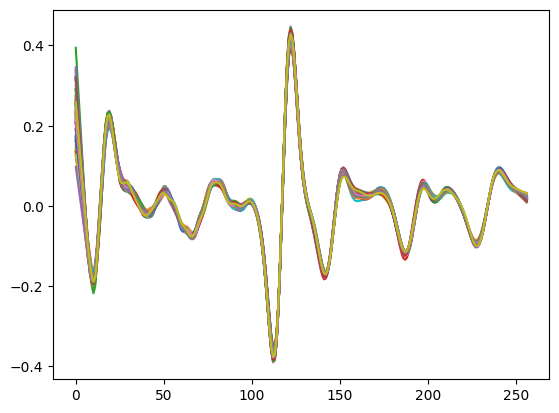

In [44]:
X = pipe.fit_transform(sainfoin_X)
plt.plot(X.T)
plt.show()
plt.close()

In [53]:
X_train, X_test, y_train, y_test = at.train_test_split(sainfoin_X, sainfoin_y, train_size=.26)

/home/bomeyering/.pyenv/versions/3.11.8/envs/nir_env/lib/python3.11/site-packages/astartes/main.py:325: ImperfectSplittingWarning: Actual train/test split differs from requested size. Requested train size of 0.26, got 0.25. Requested test size of 0.74, got 0.75. 
  warn(


In [56]:
X_train.shape
y_train


array(['S2112_R5C3', 'S2112_R7C1', 'S2112_R6C4', 'S2112_R2C4',
       'S2112_R7C3', 'S2112_R16C4', 'S2112_R12C5', 'S2112_R1C5',
       'S2112_R8C5', 'S2112_R15C5', 'S2112_R8C3', 'S2112_R11C2',
       'S2112_R8C4', 'S2112_R11C4', 'S2112_R13C4', 'S2112_R16C1',
       'S2112_R15C3', 'S2112_R12C4', 'S2112_R3C1', 'S2112_R5C4'],
      dtype=object)

In [57]:
df = pl.dataframe.DataFrame({'sample_name': pl.Series(y_train)})


In [58]:
df.write_csv('sainfoin_wetchem_selections.csv')